<div style="text-align: center; background-color: #0A6EBD; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Kaggle Competitions: Learning Agency Lab - Automated Essay Scoring 2.0  @FIT-HCMUS, VNU-HCM 📌
</div>

<div style="text-align: center; background-color: #b1d1ff; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Stage 01 - Data preprocessing 📌
</div>

# Import the library

In [352]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
cmap = plt.cm.get_cmap('coolwarm')
import warnings
warnings.filterwarnings('ignore')

# Explore data

## Load the dataset

In [353]:
df_train = pd.read_csv('../data/raw/train.csv')
df_test = pd.read_csv('../data/raw/test.csv')

In [354]:
df_train

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3
...,...,...,...
17302,ffd378d,"the story "" The Challenge of Exploing Venus "" ...",2
17303,ffddf1f,Technology has changed a lot of ways that we l...,4
17304,fff016d,If you don't like sitting around all day than ...,2
17305,fffb49b,"In ""The Challenge of Exporing Venus,"" the auth...",1


### How many rows and how many columns does the raw data have?

In [355]:
df_train.shape

(17307, 3)

### What does each line mean?

Each line contains id, content of essay and its score.

### Does the raw data have duplicate rows?

In [356]:
num_duplicated_rows = df_train.duplicated().sum()
if num_duplicated_rows == 0:
    print(f"Data have no duplicated line!")
else:
    if num_duplicated_rows > 1:
        ext = "lines"
    else:
        ext = "line"
    print(f"Data have {num_duplicated_rows} duplicated " + ext + ". Please de-deduplicate your raw data.!")

Data have no duplicated line!


### What does each column mean? 

- **id**: id of essay
- **full_text**: content of essay
- **score**: score of essay

### What data type does each column currently have?

In [357]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17307 entries, 0 to 17306
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   essay_id   17307 non-null  object
 1   full_text  17307 non-null  object
 2   score      17307 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 405.8+ KB


# Explore numerical data

### For each column with numeric data type, how are the values distributed?
- Percentage (from 0 to 100) of missing values
- The min
- The lower quartile (tứ phân vị thứ nhất)
- The median (tứ phân vị thứ hai)
- The upper quartile (tứ phân vị thứ ba)
- The max

In [358]:
def missing_ratio(x):
    missing_ratio = x.isnull().sum()/len(x)
    return missing_ratio.round(1)

def lower_quartile(x):
    return x.quantile(0.25).round(1)

def median(x):
    return x.median().round(1)

def upper_quartile(x):
    return x.quantile(0.75).round(1)

# Tạo DataFrame trống
num_col_info_df = pd.DataFrame(df_train.select_dtypes(include=[np.number]))
num_col_info_df = num_col_info_df.agg([ missing_ratio,"min",lower_quartile, median,upper_quartile,"max"])

In [359]:
num_col_info_df

,score
missing_ratio,0.0
min,1.0
lower_quartile,2.0
median,3.0
upper_quartile,4.0
max,6.0


# Explore categorical data

### For each column with a non-numeric data type, how are the values distributed?
- Percentage (from 0 to 100) of missing values
- Number of values (the values here are different values and we do not consider missing values): with columns whose type is categorical, it is a set with a finite number of categories. Directly counting the number of values in these columns doesn't make much sense, so it's better to count the number of elements of all types. (Số lượng các giá trị (các giá trị ở đây là các giá trị khác nhau và ta không xét giá trị thiếu): với cột mà có kiểu là categorical, nó là một tập hợp có số lượng hữu hạn các loại. Việc đếm trực tiếp số lượng các giá trị trong những cột này không có nhiều ý nghĩa, nên tốt hơn hết là mà sẽ đếm số lượng phần tử các loại.)
- The percentage (from 0 to 100) of each value is sorted by decreasing percentage (we do not consider missing values, the ratio is the ratio compared to the number of non-missing values): you use a dictionary to store , key is the value, value is the percentage; With the column corresponding to each type, the method is similar to above.

I will drop id column because it is not meaning for analysis.

In [360]:
cat_col_info_df = df_train['full_text']
def missing_ratio(x):
    missing_ratio = x.isnull().sum()/len(x)
    return missing_ratio
    
def num_values(x):
    result = x.value_counts().to_dict()
    return result


def value_ratios(x):

    result = {}
    counterDict = num_values(x)
    total = sum(counterDict.values())
    for key,val in counterDict.items():
        result[key] = val / total
    return result



cat_col_info_df = cat_col_info_df.agg([missing_ratio, num_values, value_ratios])


In [361]:
cat_col_info_df

missing_ratio                                                  0.0
num_values       {'Many people have car where they live. The th...
value_ratios     {'Many people have car where they live. The th...
Name: full_text, dtype: object

# Create more feature

## Number of words

In [362]:
df_train['word_count'] = df_train['full_text'].apply(lambda x: len(x.split()))

## Length

In [363]:
df_train['essay_length'] = df_train['full_text'].str.len()

## Sentences count

In [364]:
# Adding a new column 'sentences_count' that counts the sentences in 'full_text'
df_train['sentences_count'] = df_train['full_text'].str.count(r'\.')


## Paragraph count

In [365]:

# Adding a new column 'paragraph_count' that counts the paragraphs in 'full_text'
df_train['paragraph_count'] = df_train['full_text'].str.count(r'\n') + 1

In [366]:
df_train.head(5)

,essay_id,full_text,score,word_count,essay_length,sentences_count,paragraph_count
0,000d118,Many people have car where they live. The thin...,3,498,2677,13,1
1,000fe60,I am a scientist at NASA that is discussing th...,3,332,1669,19,9
2,001ab80,People always wish they had the same technolog...,4,550,3077,24,7
3,001bdc0,"We all heard about Venus, the planet without a...",4,451,2701,23,9
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,373,2208,15,11


# Visualization

## Distribution of score

count    17307.000000
mean         2.948402
std          1.044899
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: score, dtype: float64


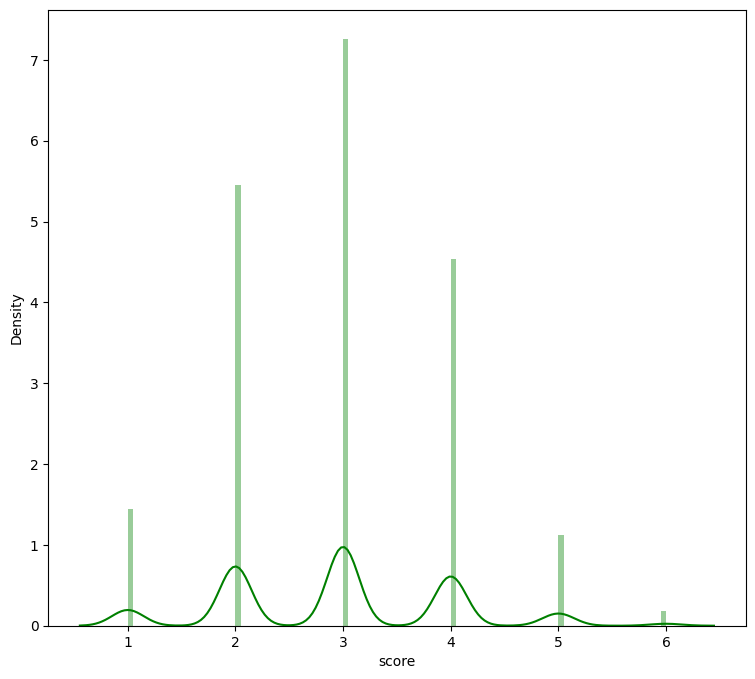

In [367]:
print(df_train['score'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(df_train['score'], color='g', bins=100, hist_kws={'alpha': 0.4});

## Scatter plot between score and essay length

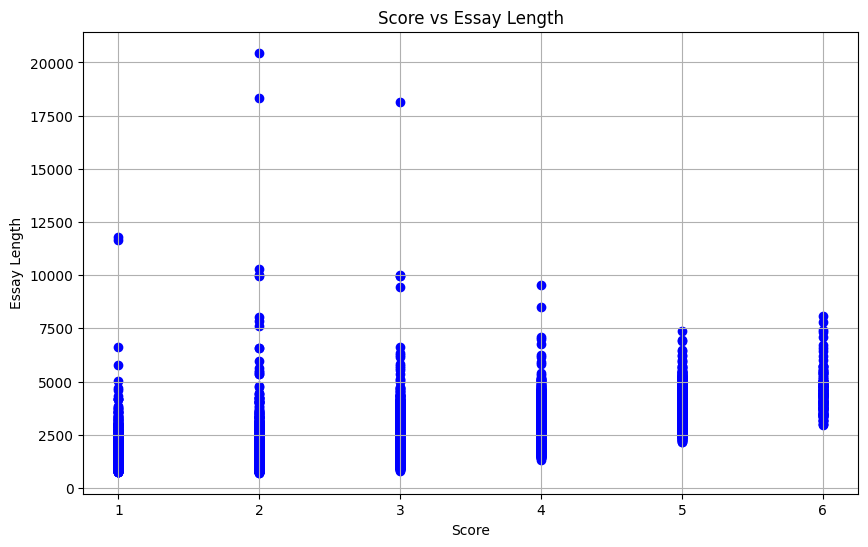

In [368]:
plt.figure(figsize=(10, 6))
plt.scatter(df_train['score'], df_train['essay_length'], color='blue')
plt.title('Score vs Essay Length')
plt.xlabel('Score')
plt.ylabel('Essay Length')
plt.grid(True)
plt.show()

In [369]:
# Tìm các dòng có giá trị LotFrontage lớn hơn 300 và lấy index của chúng

rows_to_drop = df_train.query('(essay_length > 4000 & score == 1) | (essay_length > 5000 & score == 2) | (essay_length > 5000 & score == 3) | (essay_length > 5600 & score == 4) | (essay_length > 6000 & score == 5) | (essay_length > 6000 & score == 6)').index

# Xóa các dòng có index tương ứng

df_train.drop(rows_to_drop, inplace=True)

## Scatter plot between score and Number of sentences

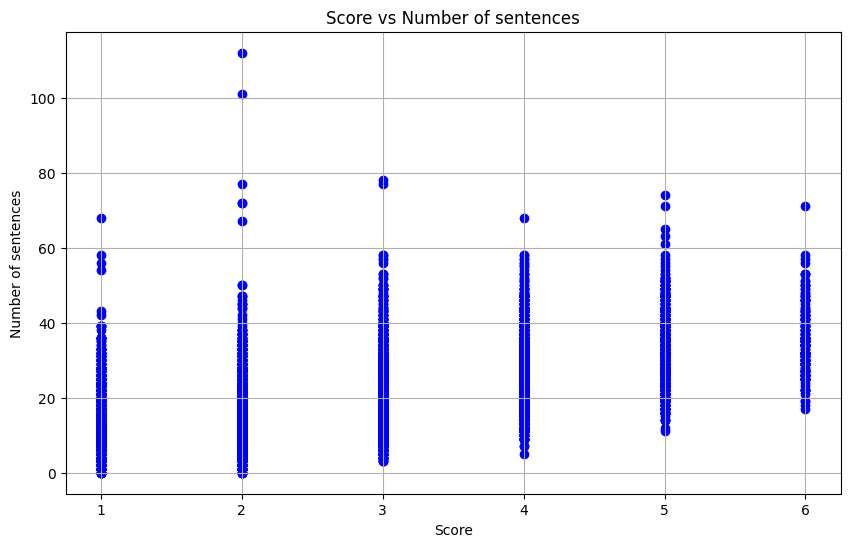

In [370]:
plt.figure(figsize=(10, 6))
plt.scatter(df_train['score'], df_train['sentences_count'], color='blue')
plt.title('Score vs Number of sentences')
plt.xlabel('Score')
plt.ylabel('Number of sentences')
plt.grid(True)
plt.show()

In [371]:
# Tìm các dòng có giá trị LotFrontage lớn hơn 300 và lấy index của chúng

rows_to_drop = df_train.query('sentences_count > 60 | (sentences_count > 50 & score == 1)').index

# Xóa các dòng có index tương ứng

df_train.drop(rows_to_drop, inplace=True)

## Scatter plot between score and Number of paragraphs

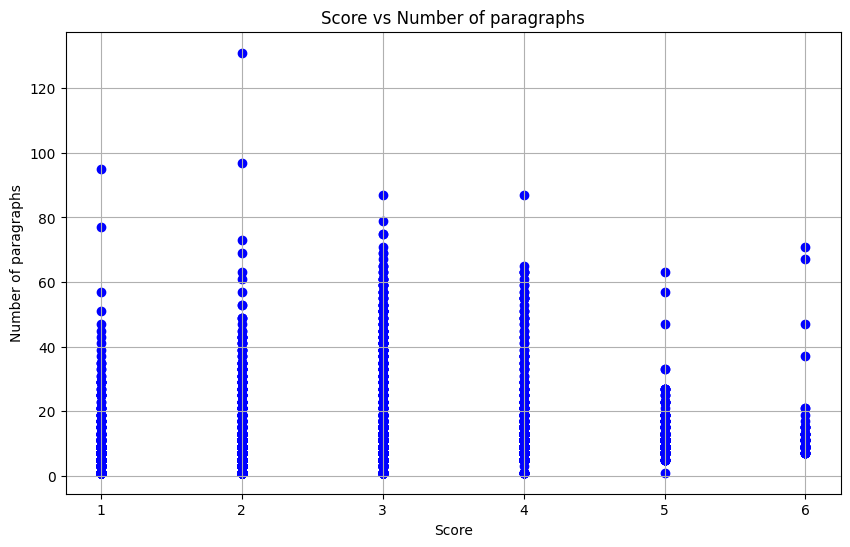

In [372]:
plt.figure(figsize=(10, 6))
plt.scatter(df_train['score'], df_train['paragraph_count'], color='blue')
plt.title('Score vs Number of paragraphs')
plt.xlabel('Score')
plt.ylabel('Number of paragraphs')
plt.grid(True)
plt.show()

In [373]:
# Tìm các dòng có giá trị LotFrontage lớn hơn 300 và lấy index của chúng

rows_to_drop = df_train.query('paragraph_count > 80 | (paragraph_count > 55 & score == 1 ) | (paragraph_count >60 & score == 2 ) | (paragraph_count > 30  & score == 5) | (paragraph_count > 25  & score == 6)').index

# Xóa các dòng có index tương ứng

df_train.drop(rows_to_drop, inplace=True)

# Save data

In [374]:
df_train.to_csv('../data/processed/train_processed.csv', index=False)